In [34]:
# Python imports
import math
import numpy
import pandas
import matplotlib.pyplot as plt

from sklearn import svm, metrics
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import permutation_importance
# from sklearn.datasets import make_classification
from sklearn import neural_network
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import mean_squared_error


# options
scale = 0  # eat it raw
scale = 2  # normalize input & output data
scale = 1  # normalize input data
# nevin = 1000 # number of events
# nevin = 10616 # number of events
# nevin = 179500 # number of events

In [35]:

print(" \n")
# Data
# fix random seed for reproducibility
seed = 69
numpy.random.seed(seed)

# load my dataset
# dfraw = pandas.read_csv("data/transfertest.csv",sep=",")
# dfraw = pandas.read_csv("data/wisctest.csv",sep=",")
# dfraw = pandas.read_csv("data/colldata_2023030200.csv",sep=",")
# read directly from zip
#dfraw = pandas.read_csv("data/colldata_2023030200.csv.zip",sep=",",compression="infer")
dfraw = pandas.read_csv("/cmsuf/data/store/user/bockjoo/CHEP2023/XRDCollectorData/colldata_2023030206.csv.zip",sep=",",compression="infer")
nevin = len(dfraw)
print('Input size  = ',nevin)
print(" \n")


 

Input size  =  4147972
 



In [36]:
"""
   Randomize the data, just to be sure not to get any pathological
   ordering effects that might harm the performance of Stochastic
   Gradient Descent.
"""

dfraw = dfraw.reindex(numpy.random.permutation(dfraw.index))

In [37]:
"""## Examine the Data

It's a good idea to get to know your data a little bit before you work
with it.

Print out a quick summary of a few useful statistics on each column:
count of examples, mean, standard deviation, max, min, and various
quantiles.

"""

print(dfraw.describe())

         Unnamed: 0     file_size    read_bytes  read_single_bytes  \
count  4.147972e+06  4.147972e+06  4.147972e+06       4.147972e+06   
mean   2.073986e+06  2.079508e+09  2.392640e+06       1.975465e+06   
std    1.197417e+06  1.042443e+09  7.045653e+07       6.073811e+07   
min    0.000000e+00 -1.000000e+00  0.000000e+00       0.000000e+00   
25%    1.036993e+06  1.255156e+09  2.911000e+03       2.836000e+03   
50%    2.073986e+06  2.001575e+09  1.216900e+04       1.209800e+04   
75%    3.110978e+06  3.017278e+09  4.465000e+04       4.449200e+04   
max    4.147971e+06  8.663526e+09  1.387470e+10       1.044610e+10   

       read_vector_bytes    start_time      end_time  operation_time  \
count       4.147972e+06  4.147972e+06  4.147972e+06    4.147972e+06   
mean        1.345845e+05  1.677738e+12  1.677738e+12    4.461784e+00   
std         1.067420e+07  1.580829e+06  1.582923e+06    1.462942e+02   
min         0.000000e+00  1.677729e+12  1.677733e+12    0.000000e+00   
25%      

In [54]:
# select columns & descibe data again

###dfall = dfraw[['server_host','file_size','read_bytes','ipv6','throughput']]
#dfall = dfraw[['server_host','file_size','read_bytes','throughput']]
dfall = dfraw[['server_host','file_size','read_bytes','ipv6', 'operation_time','throughput']]
df1 = dfall.loc[(dfall['throughput'] > .0)]
df2 = df1.loc[(df1['file_size'] > .0)]
df  = df2.loc[(df2['read_bytes'] > .0)]
df.insert(3, "read_bytes_per_fsize", df['read_bytes']/df['file_size'], True)
print(df.describe())
nev = len(df)
print('Filtered size = ',nev)

          file_size    read_bytes  read_bytes_per_fsize  operation_time  \
count  3.646200e+04  3.646200e+04          3.646200e+04    36462.000000   
mean   2.041463e+09  1.605934e+08          2.296001e-01      113.009572   
std    1.468561e+09  6.133640e+08          4.089769e-01      373.210795   
min    2.320000e+04  1.010000e+02          2.386281e-08        1.000000   
25%    7.130847e+08  3.000000e+02          2.828879e-07        3.000000   
50%    1.960255e+09  6.153830e+06          2.565328e-03        5.000000   
75%    3.075443e+09  1.384652e+08          9.779691e-02       59.000000   
max    8.663526e+09  1.044645e+10          2.032071e+00     3782.000000   

         throughput  
count  3.646200e+04  
mean   2.671182e+06  
std    8.776455e+06  
min    1.463415e-01  
25%    1.365000e+02  
50%    1.425999e+05  
75%    2.102010e+06  
max    1.965794e+08  
Filtered size =  36462


In [55]:
df.describe()

,file_size,read_bytes,read_bytes_per_fsize,operation_time,throughput
count,3.646200e+04,3.646200e+04,3.646200e+04,36462.000000,3.646200e+04
mean,2.041463e+09,1.605934e+08,2.296001e-01,113.009572,2.671182e+06
std,1.468561e+09,6.133640e+08,4.089769e-01,373.210795,8.776455e+06
min,2.320000e+04,1.010000e+02,2.386281e-08,1.000000,1.463415e-01
25%,7.130847e+08,3.000000e+02,2.828879e-07,3.000000,1.365000e+02
50%,1.960255e+09,6.153830e+06,2.565328e-03,5.000000,1.425999e+05
75%,3.075443e+09,1.384652e+08,9.779691e-02,59.000000,2.102010e+06
max,8.663526e+09,1.044645e+10,2.032071e+00,3782.000000,1.965794e+08


In [61]:

# 90/10% split for training/testing
dataset = df[:int(0.9*nev)].values
print('Training size = ',len(dataset))
datasettest = df[int(0.9*nev):nev].values
print('Testing size  = ',len(datasettest))

print(dataset[21:23,:])

print(datasettest[21:23,:])

# split into input (X) and output (Y) variables
#
# train sample
X = dataset[:,1:6]
Y = dataset[:,6]
datasize = len(Y)
print("Data size: %06d " % (datasize))
dssize = datasize
Xsize = 3


Training size =  32815
Testing size  =  3647
[['gftp-3.t2.ucsd.edu' 196579440 196579440 1.0 False 28 7020694.285714285]
 ['gftp-11.t2.ucsd.edu' 2452150280 159 6.484105044328686e-08 False 3 53.0]]
[['gftp-6.t2.ucsd.edu' 1919376545 261 1.359816554390582e-07 False 6 43.5]
 ['gftp-7.t2.ucsd.edu' 194971388 194971388 1.0 False 6 32495231.33333333]]
Data size: 032815 


In [62]:
# test sample
Xtest = datasettest[:,1:6]
Ytest = datasettest[:,6]
datasizetest = len(Ytest)
print("Data size Test: %06d " % (datasizetest))
dssizetest = datasizetest
Xsizetest = 3

Data size Test: 003647 


In [63]:
print(" \n")

# scale data?
if(scale==1):
   scaler = StandardScaler()  
   # Don't cheat - fit only on training data
   scaler.fit(X)  
   X = scaler.transform(X)  
   # apply same transformation to test data
   Xtest = scaler.transform(Xtest)  
   #dimi!
   if(scale==2):
     scaler.fit(Y)
     Y = scaler.transform(Y)  
     # apply same transformation to test data
     Ytest = scaler.transform(Ytest)  

In [64]:
# Gradient Boosting Regression

# GBR I

params = {
#   "n_estimators": 500,
    "n_estimators": 1000,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

dbreg = GradientBoostingRegressor(**params)
dbreg.fit(X, Y)

dbregpredicted = dbreg.predict(Xtest)
print("\n GB Regressor I")
print("GBR  I R score = ",dbreg.score(Xtest, Ytest))
print("Root Mean Sq Error = ",math.sqrt(mean_squared_error(Ytest,dbregpredicted)))
for i in range(0,9):
  print("i, true, predicted => ",i,Ytest[i],dbregpredicted[i])
#print(" \n")


 GB Regressor I
GBR  I R score =  0.9789342516814903
Root Mean Sq Error =  1254706.3718372155
i, true, predicted =>  0 30941.13559322034 2279.9606454358695
i, true, predicted =>  1 18237.48504983389 -1191.5838413896315
i, true, predicted =>  2 334.3333333333333 11146.468081072118
i, true, predicted =>  3 92.66666666666669 11146.468081072118
i, true, predicted =>  4 690863.5 719407.4812824213
i, true, predicted =>  5 268033.8233333333 222747.3819249373
i, true, predicted =>  6 3304563.675 2595264.071225548
i, true, predicted =>  7 28.0 9751.399784001565
i, true, predicted =>  8 83.33333333333333 11146.468081072118


## Plot Feature Importance

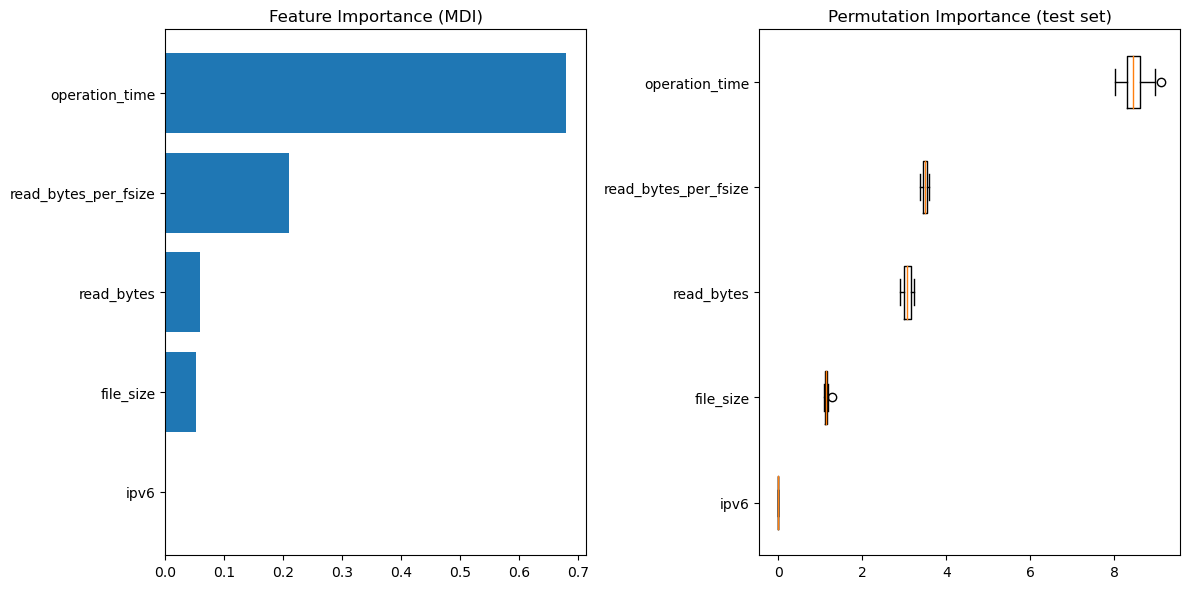

In [77]:
# Plot feature importance
feature_importance = dbreg.feature_importances_
sorted_idx = numpy.argsort(feature_importance)
pos = numpy.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, numpy.array(df.columns[1:6])[sorted_idx])
plt.title("Feature Importance (MDI)")
#plt.savefig("FeatureImportance.jpg")

result = permutation_importance(
    dbreg, Xtest, Ytest, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=numpy.array(df.columns[1:6])[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
#plt.show()
plt.savefig("FeaturePermutationImportance.pdf")

## Plot Training Deviance

In [74]:
# Plot training deviance
test_score = numpy.zeros((params["n_estimators"],), dtype=numpy.float64)
for i, y_pred in enumerate(dbreg.staged_predict(Xtest)):
    test_score[i] = mean_squared_error(Ytest, y_pred)

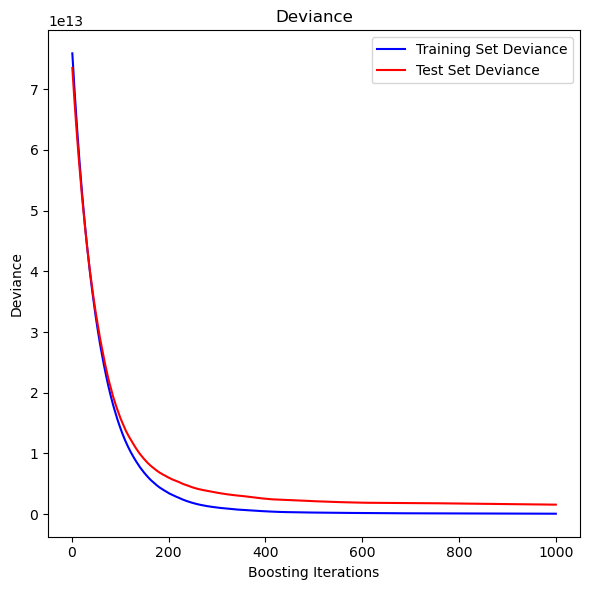

In [78]:
fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    numpy.arange(params["n_estimators"]) + 1,
    dbreg.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    numpy.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
#if(saveplots==1):
#plt.savefig('db-xgb-training.png')
plt.savefig('db-xgb-training.pdf')
plt.show()